In [1]:
import h5py
import numpy as np
import networkx as nx

import matplotlib.pyplot as plt
import seaborn as sns
import copy

from tqdm import tqdm
import pandas as pd

import os

import nexusformat.nexus as nex

f = nex.nxload("f:\\git\\eeg_prep\\processed_files\\001_000500_000500.hdf5")

# f = nex.nxload("/media/dan/Data/data/sourcesink_eegprep_calculations/processed_files/001_000500_000500.hdf5")
print(f.tree)

root:NXroot
  @date_created = '2024-10-03 16:02:40'
  @description = 'HDF5 file containing iEEG data and calculation...'
  data:NXgroup
    @description = 'windows are shaped (winsize_samps, len(channel...'
    A_mask = bool(609)
    A_mats = float64(118x118x609)
    A_mean = float64(118x118x1)
    A_medians = float64(609)
    A_thresh = 4.466130102425403
    window_indexs = int64(609x2)
    window_reconstructionError = float64(609)
    windows = float64(512x118x609)
  metadata:NXgroup
    N_samples = 312064
    N_wins = 609
    STEPSIZE_MSEC = 500
    STEPSIZE_SAMPS = 512
    WINSIZE_MSEC = 500
    WINSIZE_SAMPS = 512
    channels = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', '...
    patient_info:NXgroup
      aal = ['ParaHippocampal_R', 'Hippocampus_R', 'Hippocampus_R', ...
      aal2 = ['ParaHippocampal_R', 'Hippocampus_R', 'Hippocampus_R', ...
      age_days_at_recording = float64(118)
      age_years_at_recording = float64(118)
      bad_channel = ['False', 'False', 'F

In [2]:
hdf5_path = "F:\\git\\eeg_prep\\processed_files"
# hdf5_path = "/media/dan/Data/git/eeg_prep/processed_files"

files = os.listdir(hdf5_path)
    
# load all files into individual lists
channels = {}
brainnetome = {}
harvard_oxford = {}
miccai = {}
aal = {}
white_matter = {}
soz = {}
ilae = {}
pids = []
a_mats = {}
a_masks = {}
raw_data = {}


for f in tqdm(files):
    if f.endswith(".hdf5"):
        pid = int(f.split("_")[0])
        pids.append(pid)
        with h5py.File(os.path.join(hdf5_path,f), "r") as f:
            channels[pid] = f['metadata']["channels"][:]
            brainnetome[pid] = f['metadata']['patient_info']["brainnetome"][:]
            harvard_oxford[pid] = f['metadata']['patient_info']["harvard-oxford"][:]
            miccai[pid] = f['metadata']['patient_info']["miccai"][:]
            aal[pid] = f['metadata']['patient_info']["aal"][:]
            white_matter[pid] = f['metadata']['patient_info']["white_matter"][:].astype(bool)
            # convert from bytes to string
            channels[pid] = [x.decode('utf-8') for x in channels[pid]]
            brainnetome[pid] = [x.decode('utf-8') for x in brainnetome[pid]]
            harvard_oxford[pid] = [x.decode('utf-8') for x in harvard_oxford[pid]]
            miccai[pid] = [x.decode('utf-8') for x in miccai[pid]]
            aal[pid] = [x.decode('utf-8') for x in aal[pid]]

            soz[pid] = f['metadata']["patient_info"]['soz'][:].astype(bool)
            ilae[pid] = f['metadata']["patient_info"]['ilae'][:]

            a_mats[pid] = f['data']['A_mats'][:]
            a_masks[pid] = f['data']['A_mask'][:].astype(bool)
            # raw_data[pid] = f['data']['windows'][:]

  0%|          | 0/72 [00:00<?, ?it/s]

100%|██████████| 72/72 [00:43<00:00,  1.66it/s]


In [3]:
pid = 64
As = a_mats[pid][:,:, a_masks[pid]]
diags = np.zeros((As.shape[0],As.shape[-1]))

for i in range(As.shape[-1]):
    diags[:,i] = np.diag(As[:,:,i])
    np.fill_diagonal(As[:, :, i], 0)
# As = np.diff(As,axis=-1)

# As = np.cumsum(np.abs(As), axis=-1)
# normalize 0-1
# tot_mag = tot_mag / np.max(tot_mag)

s = soz[pid]
soz_soz = As[s, :, :][:, s, :]
soz_noz = As[s, :, :][:, ~s,:]
noz_soz = As[~s, :, :][:, s,:]
noz_noz = As[~s, :,:][:, ~s,:]

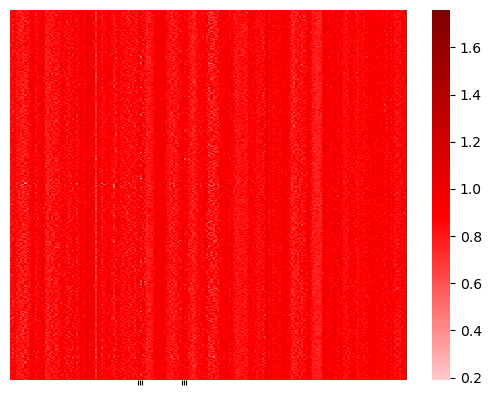

In [201]:
tick_positions = [idx for idx, value in enumerate(s) if value]

ax = sns.heatmap(diags.T,cmap="seismic",center=0)
# Remove all ticks
ax.set_xticks([])
ax.set_yticks([])

ax.set_xticks(tick_positions)
# ax.set_yticks(tick_positions)

# Remove tick labels
ax.set_xticklabels([])
ax.set_yticklabels([]);

In [166]:
new = []
for i in tqdm(range(As.shape[-1])):
    rows = []
    for r in range(As.shape[0]):
        m = np.argmax(As[:,r,i])
        q = np.zeros(As.shape[0])
        q[m] = 1
        rows.append(q)
    new.append(rows)

new=np.array(new)

tick_positions = [idx for idx, value in enumerate(s) if value]
for i in tqdm(range(new.shape[0])):
    plt.figure()
    ax =sns.heatmap(new[i,:,:],cmap="Grays",square=True)
    # Remove all ticks
    ax.set_xticks([])
    ax.set_yticks([])
   
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    
    # Remove tick labels
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.axis("equal")
    plt.savefig(os.path.join('graphs','cols', f"{i:05}.png"))
    plt.close()

100%|██████████| 604/604 [02:19<00:00,  4.32it/s]


In [172]:
import os
from PIL import Image
import imageio

# Set your folder path and output file name
folder_path = 'graphs/cols'
output_file = 'cols.gif'

# List all image files in the folder
images = []
for file_name in sorted(os.listdir(folder_path)):
    if file_name.endswith(('png', 'jpg', 'jpeg', 'bmp')):
        file_path = os.path.join(folder_path, file_name)
        images.append(imageio.imread(file_path))

# Create and save the GIF
imageio.mimsave(output_file, images, fps=60, loop=0)  # fps sets the speed of the gif

print(f"GIF saved as {output_file}")


C:\Users\wirel\AppData\Local\Temp\ipykernel_9748\3823695618.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved as cols.gif


In [173]:
import os
from PIL import Image
import imageio

# Set your folder path and output file name
folder_path = 'graphs/rows'
output_file = 'rows.gif'

# List all image files in the folder
images = []
for file_name in sorted(os.listdir(folder_path)):
    if file_name.endswith(('png', 'jpg', 'jpeg', 'bmp')):
        file_path = os.path.join(folder_path, file_name)
        images.append(imageio.imread(file_path))

# Create and save the GIF
imageio.mimsave(output_file, images, fps=60, loop=0)  # fps sets the speed of the gif

print(f"GIF saved as {output_file}")


C:\Users\wirel\AppData\Local\Temp\ipykernel_9748\3779275618.py:14: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(file_path))


GIF saved as rows.gif


In [5]:
def plot_timeseries(mat, title=None):
    fig,ax = plt.subplots(1,1,figsize=(20,5))
    for r in range(mat.shape[0]):
        for c in range(mat.shape[1]):
            if sum(mat[r,c,:]) == 0:
                continue
            ax.plot(mat[r,c,:],label=f"{r},{c}", alpha=0.25, color='b', linewidth=.2)
    plt.grid()
    if title is not None:
        plt.title(title)
        

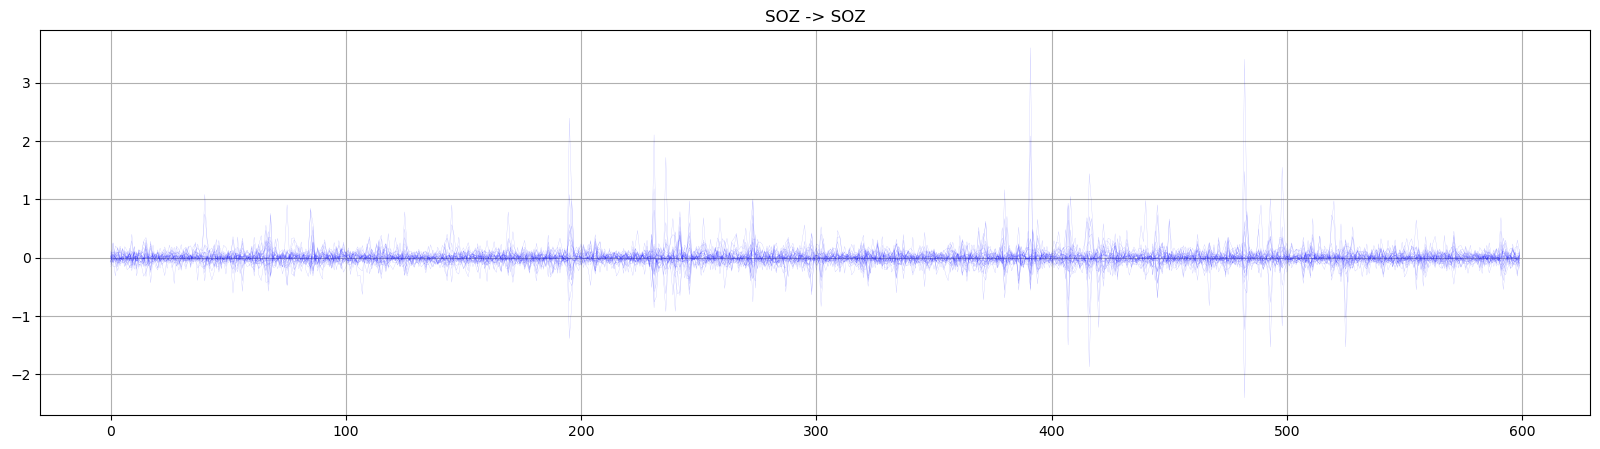

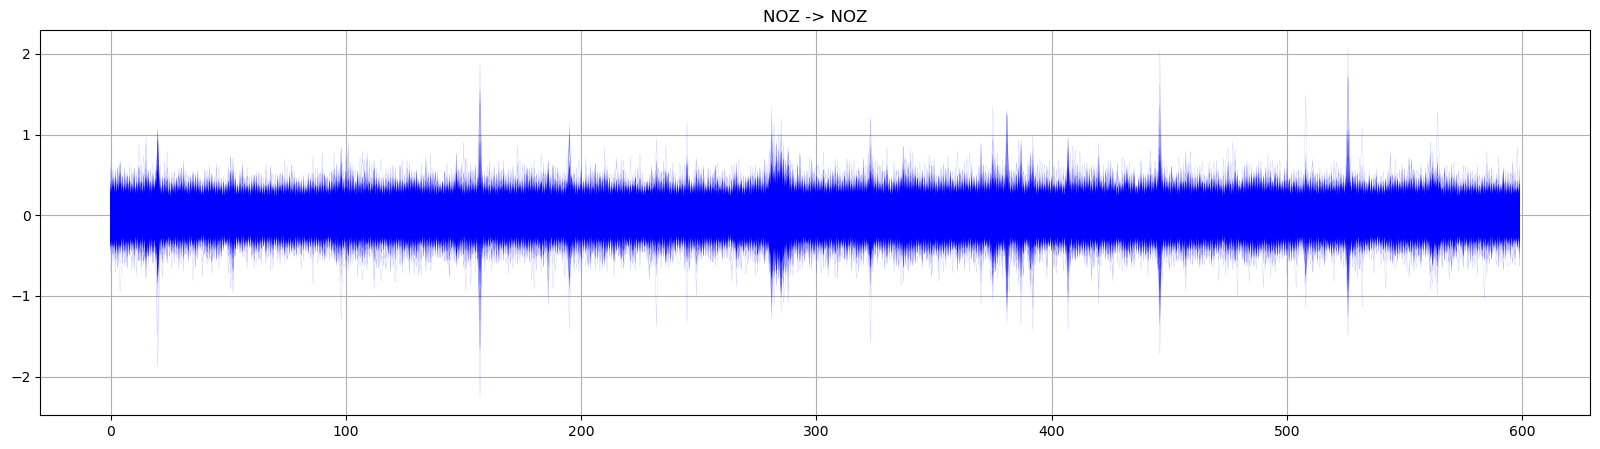

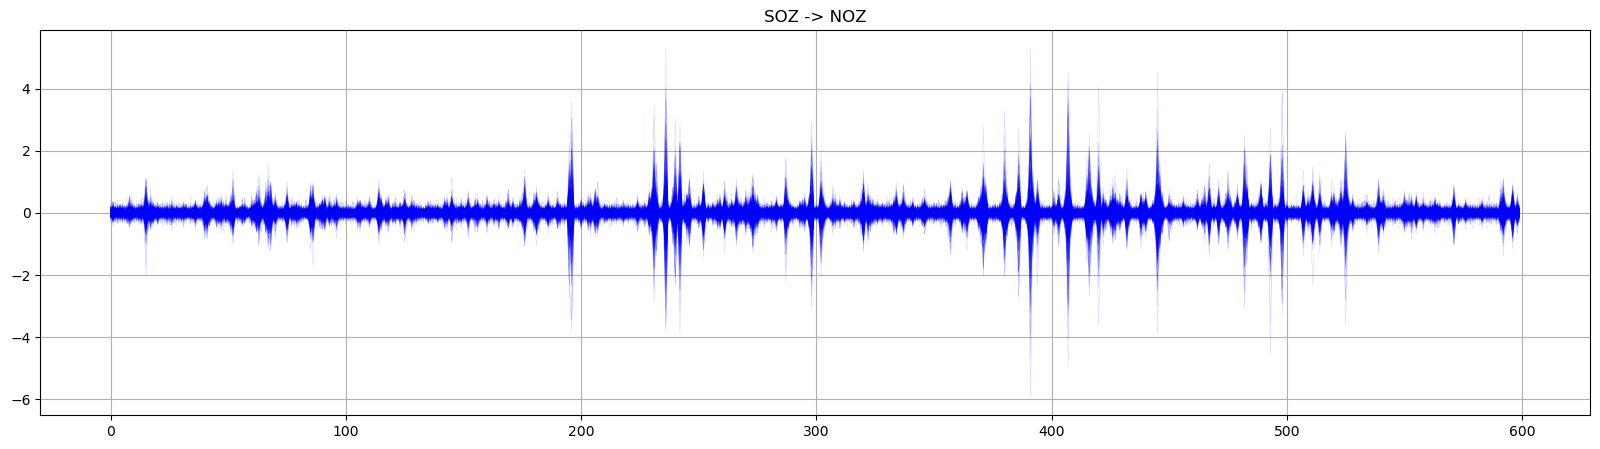

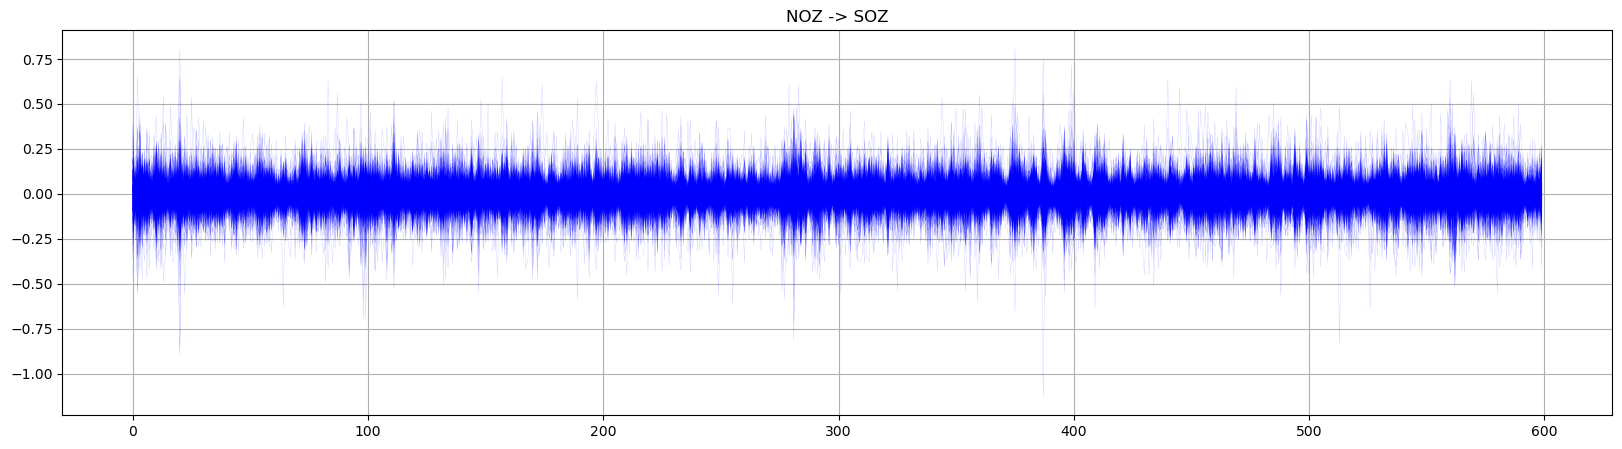

In [6]:
plot_timeseries(soz_soz, "SOZ -> SOZ")
plot_timeseries(noz_noz, "NOZ -> NOZ")
plot_timeseries(soz_noz, "SOZ -> NOZ")
plot_timeseries(noz_soz, "NOZ -> SOZ")

In [155]:
import networkx as nx
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
from tqdm import tqdm

node_colors = ['red' if value else 'green' for value in s]

for i in tqdm(range(As.shape[-1])):
    edges = []
    for r in range(As.shape[0]):
        edges.append((r, np.argmax(As[r, :, i])))

    G = nx.DiGraph()
    G.add_nodes_from(range(As.shape[0]))  # Add nodes explicitly to preserve order
    G.add_edges_from(edges)  # Add edges as before

    # Calculate positions
    num_nodes = As.shape[0]
    angle_step = 2 * np.pi / num_nodes
    pos = {n: (np.sin(n * angle_step), np.cos(n * angle_step)) for n in range(num_nodes)}
    
    labels = {x: x for x in range(num_nodes)}

    # Draw the graph
    plt.figure()
    ax = plt.gca()  # Get current axis

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_size=50, node_color=node_colors, ax=ax)
    nx.draw_networkx_labels(G, pos, labels, font_size=6, ax=ax)

    # Draw arrows for edges using FancyArrowPatch
    for (start, end) in G.edges:
        if start != end:  # Ignore self-loops
            start_pos = np.array(pos[start])
            end_pos = np.array(pos[end])

            # Shorten the arrow length to keep it within the bounds of the plot
            direction = end_pos - start_pos
            length = np.linalg.norm(direction)
            unit_direction = direction / length
            
            arrow_start = start_pos + 0.01 * unit_direction
            arrow_end = end_pos - 0.01 * unit_direction

            # Draw the arrow
            arrow = FancyArrowPatch(
                arrow_start, arrow_end,
                arrowstyle='-|>',  # Just the arrowhead
                color='k',
                mutation_scale=15,  # Arrowhead size
                linewidth=0,
                zorder=2  # Make sure arrow is above nodes
            )
            ax.add_patch(arrow)

    plt.axis("equal")
    plt.savefig(os.path.join('graphs', f"{i:05}.png"))
    plt.close()


 24%|██▍       | 144/604 [01:41<05:23,  1.42it/s]


KeyboardInterrupt: 